In [33]:
pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=5117cf811b2a9578b908c933cadc7fdb7d6eaa38e5aea95d64a8facc961c76a0
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [34]:
import os, sys, gc
import os.path as osp
import argparse
import random
import cv2
import numpy as np
import json
import import_ipynb
from google.colab.patches import cv2_imshow
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torchvision
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
from imgaug import augmenters as iaa
from IPython import display
from PIL import Image, ImageDraw
import matplotlib
import matplotlib.pyplot as plt
from skimage import color
from skimage.transform import rescale, resize
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, binary_opening, binary_erosion, binary_dilation

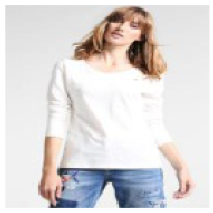

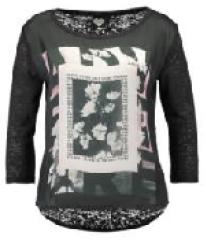

In [5]:
img1 = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrialData/model.png')
img2 = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrialData/garment.png')
cv2_imshow(img1)
cv2_imshow(img2)

In [6]:
def get_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--j', type = int, default = 1) # number of workers used for loading data
    parser.add_argument('--b', type = int, default = 1) # batch size
    parser.add_argument("--dataroot")#, default = "Data")
    parser.add_argument("--datamode", default = "Train")
    parser.add_argument("--stage", default = "Stitch", help = 'Shape, Stitch, Refine')
    parser.add_argument("--data_list", default = "train_pairs.txt")
    parser.add_argument("--radius", type = int, default = 5) # skeleton width
    parser.add_argument("--grid_size", type = int, default = 5)
    parser.add_argument('--lr', type = float, default = 0.0002, help = 'Initial Learning Rate')
    parser.add_argument("--display_count", type = int, default = 1000)
    parser.add_argument("--save_count", type = int, default = 100)
    parser.add_argument("--shuffle", action ='store_true', help = 'Shuffle Input Data')
    parser.add_argument("--epochs", type = int, default = 5) 
    parser.add_argument("--input_channel", type = int, default = 6)
    parser.add_argument("--decay_epoch", type = int, default = 1) 
    parser.add_argument('--results', type = str, default = 'Results', help = 'Save Results')
    parser.add_argument("--critic", type = int, default = 10) # Number of times after which to update Discriminator.
    parser.add_argument("--save_model", type = int, default = 2)
    parser.add_argument('-f')
    opt = parser.parse_args()
    return opt

In [7]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([iaa.Affine( rotate = 40 , mode='symmetric'),
                                  # iaa.Scale((128, 128)), iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))), iaa.Fliplr(0.5), iaa.Affine(rotate=(-40, 40), 
                                  # mode='symmetric'),iaa.Sometimes(0.25, iaa.OneOf([iaa.Dropout(p=(0, 0.1)), iaa.CoarseDropout(0.1, size_percent=0.5)])), 
                                  # iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
                                ])
        
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [8]:
class ImgAugTransformStitching:
    def __init__(self):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        self.aug = iaa.Sequential([iaa.Affine(rotate = 40, mode = 'symmetric'), iaa.Affine(translate_percent = {"x":0.2, "y": 0.1}, mode = 'symmetric'
                  # rotate=(-45, 45), shear=(-16, 16), order=[0, 1], cval=(0, 255), iaa.Scale((128, 128)), iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))), 
                  # iaa.Fliplr(0.5), iaa.Affine( rotate = 20 , mode = 'symmetric'), iaa.Sometimes(0.25, iaa.OneOf([iaa.Dropout(p = (0, 0.1)), 
                  # iaa.CoarseDropout(0.1, size_percent = 0.5)])), iaa.AddToHueAndSaturation(value = (-10, 10), per_channel = True)        
                  )])
        
    def __call__(self, img, img1, img2):
        img = np.array(img)
        img1 = np.array(img1)
        img2 = np.array(img2)
        return self.aug.augment_image(img), self.aug.augment_image(img1), self.aug.augment_image(img2)

In [9]:
class data_loader():
    def __init__(self,mode="train"):
        path_ = os.getcwd()
        self.root = '/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/'
        self.datamode = mode
        self.fine_height = 128
        self.fine_width = 128
        self.radius = 3
        self.transform = transforms.Compose([transforms.Resize((self.fine_height,self.fine_height)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.transform_input = transforms.Compose([ImgAugTransform(), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.rotate = ImgAugTransform()
        
    def transformData(self, src, mask, target, cloth, skel):
        # Resize
        resize = transforms.Resize(size = (128, 128))
        src = resize(src) # Source with missing cloth
        mask = resize(mask) # mask of the missing cloth
        target = resize(target) # target/ Ground truth
        cloth = resize(cloth) # Cloth ground truth, how it should look before applying
        skel = resize(skel) # skeleton

        src = TF.to_tensor(src)
        mask = TF.to_tensor(mask)
        target = TF.to_tensor(target)
        cloth = TF.to_tensor(cloth)
        skel = TF.to_tensor(skel)  
        
        src = TF.normalize(src,(0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        mask = TF.normalize(mask, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        target = TF.normalize(target,(0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        cloth = TF.normalize(cloth,(0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        skel = TF.normalize(skel,(0.5, 0.5, 0.5), (0.5, 0.5, 0.5))     
        return src, mask, target, cloth, skel    

    def get_binary_from_img(self, image_name):
        loader2 = transforms.Compose([transforms.Resize((256, 192)), transforms.ToTensor()])
        # load image and return cuda tensor
        image = Image.fromarray(np.uint8(image_name))
        image = loader2(image).float()
        better_contrast = image.permute(1, 2, 0).detach().cpu().numpy()
        better_contrast[better_contrast>1] = 1
        thresh = threshold_otsu(cv2.cvtColor(better_contrast, cv2.COLOR_BGR2GRAY))
        binary = better_contrast > thresh
        return binary

    def get_binary(self, image_name):
        loader2 = transforms.Compose([transforms.Resize((256, 192)), transforms.ToTensor()])
        # load image and return cuda tensor
        image = Image.open(image_name)
        image = loader2(image).float()
        better_contrast = image.permute(1, 2, 0).detach().cpu().numpy()
        better_contrast[better_contrast>1] = 1
        thresh = threshold_otsu(better_contrast)
        binary = better_contrast > thresh
        return binary

    def get_img(self, im_name, c_name):
        # person image 
        im = plt.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_img/000003_0.jpg')
        cm = plt.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_color/000025_1.jpg')

        # load parsing image
        parse_name = im_name.replace('.jpg', '.png')
        im_parse = Image.open(osp.join('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_img/', parse_name))
        parse_array = np.array(im_parse)
        parse_cloth = (parse_array == 5).astype(np.float32) + (parse_array == 6).astype(np.float32) + (parse_array == 7).astype(np.float32) + \
        (parse_array == 9).astype(np.float32)+ (parse_array == 15).astype(np.float32) + (parse_array == 3).astype(np.float32) + (parse_array == 14).astype(np.float32) 
        #b = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrialData/parse.png')
        #cv2.imshow(b)
        pcm = self.get_binary_from_img(parse_cloth)

        pose_name = im_name.replace('.jpg', '_keypoints.json')
        with open(osp.join('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_pose/', pose_name), 'r') as f:
            pose_label = json.load(f)
            pose_data = pose_label['people'][0]['pose_keypoints']
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1, 3))

        point_num = pose_data.shape[0]
        r = 7       #self.radius
        # pdb.set_trace()
        coop = {}
        coop2 = {}
        ai = 0
        for lol,i in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 11]): # removing head and legs joints, keeping hip and hands
            pointx = pose_data[i, 0]
            pointy = pose_data[i, 1]
            if pointx > 1 and pointy > 1:
                coop[ai] = (pointx,pointy)
                coop2[ai] = (pointx,pointy)
                ai = ai + 1
            else:
                coop2[ai] = (pointx, pointy)
                ai = ai + 1

        # creating skeleton
        bone_list = [[x[0], x[1]] for key, x in coop2.items()]
        # bone_list = bone_list.numpy()
        bone_list = np.array(bone_list) - 1
        itemindex = np.where(bone_list == -1)
        if len(itemindex[0]) == 0:
            it = 100
        else:
            it = np.unique(itemindex[0])
        
        one_map = Image.new('RGB', (192, 256))
        draw = ImageDraw.Draw(one_map)
        if np.logical_not(np.isin(it,0)).all() and np.logical_not(np.isin(it,1)).all():
            draw.line((bone_list[0][0], bone_list[0][1], bone_list[1][0], bone_list[1][1]), fill = 'red', width = 14)
        if np.logical_not(np.isin(it,1)).all() and np.logical_not(np.isin(it,2)).all():
            draw.line((bone_list[1][0], bone_list[1][1], bone_list[2][0], bone_list[2][1]), fill = 'blue', width = 14)
        if np.logical_not(np.isin(it,3)).all() and np.logical_not(np.isin(it,2)).all():
            draw.line((bone_list[2][0], bone_list[2][1], bone_list[3][0], bone_list[3][1]), fill = 'white', width = 14)
        if np.logical_not(np.isin(it,0)).all() and np.logical_not(np.isin(it,4)).all():
            draw.line((bone_list[0][0], bone_list[0][1], bone_list[4][0], bone_list[4][1]), fill = 'orange', width = 14)
        if np.logical_not(np.isin(it,4)).all() and np.logical_not(np.isin(it,5)).all():    
            draw.line((bone_list[4][0], bone_list[4][1], bone_list[5][0], bone_list[5][1]), fill = 'orchid', width = 14)
        if np.logical_not(np.isin(it,6)).all() and np.logical_not(np.isin(it,5)).all():
            draw.line((bone_list[5][0], bone_list[5][1], bone_list[6][0], bone_list[6][1]), fill = 'yellow', width = 14)
        if np.logical_not(np.isin(it,0)).all() and np.logical_not(np.isin(it,1)).all():
            draw.line((bone_list[1][0], bone_list[1][1], bone_list[7][0], bone_list[7][1]), fill = 'gold', width = 14)
        if np.logical_not(np.isin(it,4)).all() and np.logical_not(np.isin(it,8)).all():
            draw.line((bone_list[4][0], bone_list[4][1], bone_list[8][0], bone_list[8][1]), fill = 'pink', width = 14)
        if np.logical_not(np.isin(it,7)).all() and np.logical_not(np.isin(it,8)).all():
            draw.line((bone_list[7][0], bone_list[7][1], bone_list[8][0], bone_list[8][1]), fill = 'brown', width = 14)
        #a = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrialData/skel.png')
        #cv2.imshow(a)
        source = im * pcm 
        # face = im * (1 - pcm)
        source[source == 0] = 255
        # face[face == 0] = 255
        mask = plt.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_mask/00003.png')
        lol = self.get_binary('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_mask/00003.png')
        lol2 = source * (1 - lol)
        lol2[lol2 == 0] = 255    
        lol3 = source*(lol)
        lol3[lol3 == 0] = 255        
        input = Image.fromarray(np.uint8(lol2))
        mask = Image.fromarray(np.uint8(mask))
        style = Image.fromarray(np.uint8(lol3))
        target = Image.fromarray(np.uint8(source))
        cloth = Image.fromarray(np.uint8(cm))
        style_ = self.transform(style)
        cloth = self.transform(cloth)
        source, mask, target, targ, skel = self.transformData(input, mask, target, style, one_map)
        del lol3, lol2, pcm, im, parse_cloth, im_parse, lol
        return source, mask, style_, target, targ, skel, cloth

In [10]:
class PolyDatasetShape(data.Dataset):
    def __init__(self, height):
        super(PolyDatasetShape, self).__init__()
        path_ = os.getcwd()
        self.root = '/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/'
        self.datamode = 'train'  # train or test
        self.data_list = "train_pairs.txt"
        self.fine_height = height
        self.fine_width = 128
        self.radius = 3
        self.transform = transforms.Compose([transforms.Resize((self.fine_height, self.fine_height)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.transform_input = transforms.Compose([ImgAugTransform(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # loading data list
        im_names = []
        c_names = []
        with open('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_pairs.txt', 'r') as f:
            for line in f.readlines():
                im_name, c_name = line.strip().split()
                im_names.append(im_name)
                c_names.append(c_name)
        self.im_names = im_names
        self.c_names = c_names
        self.rotate = ImgAugTransform()

    def name(self):
        return "PolyDatasetShape"

    def transformData(self, src, mask, target, cloth, skel):
        # Resize
        resize = transforms.Resize(size = (128, 128))
        src = resize(src)  # Source with missing cloth
        mask = resize(mask)  # mask of the missing cloth
        target = resize(target)  # target/ Ground truth
        cloth = resize(cloth)  # Cloth ground truth, how it should look before applying
        skel = resize(skel)  # skeleton

        if random.random() > 0.5:
            src = self.rotate(src)
            mask = self.rotate(mask)
            target = self.rotate(target)
            cloth = self.rotate(cloth)
            skel = self.rotate(skel)

        # Transform to tensor
        src = TF.to_tensor(src)
        mask = TF.to_tensor(mask)
        target = TF.to_tensor(target)
        cloth = TF.to_tensor(cloth)
        skel = TF.to_tensor(skel)
        src = TF.normalize(src, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        mask = TF.normalize(mask, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        target = TF.normalize(target, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        cloth = TF.normalize(cloth, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        skel = TF.normalize(skel, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        return src, mask, target, cloth, skel

    def get_binary_from_img(self, image_name):
        loader2 = transforms.Compose([transforms.Resize((256, 192)), transforms.ToTensor()])
        # load the image and return cuda tensor
        image = Image.fromarray(np.uint8(image_name))
        image = loader2(image).float()
        better_contrast = image.permute(1, 2, 0).detach().cpu().numpy()
        better_contrast[better_contrast > 1] = 1
        thresh = threshold_otsu(cv2.cvtColor(better_contrast, cv2.COLOR_BGR2GRAY))
        binary = better_contrast > thresh
        return binary

    def get_binary(self, image_name):
        loader2 = transforms.Compose([transforms.Resize((256, 192)), transforms.ToTensor()])
        # load the image and return cuda tensor
        image = Image.open(image_name)
        image = loader2(image).float()
        better_contrast = image.permute(1, 2, 0).detach().cpu().numpy()
        better_contrast[better_contrast > 1] = 1
        thresh = threshold_otsu(better_contrast)
        binary = better_contrast > thresh
        return binary 

    def __getitem__(self, index):
        c_name = self.c_names[index]
        im_name = self.im_names[index]

        # model image
        im = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_img/000003_0.jpg')
        # garment image
        cm = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_color/000025_1.jpg')

        # load parsing image
        parse_name = im_name.replace('.jpg', '.png')
        im_parse = Image.open(osp.join('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_img/', parse_name))
        parse_array = np.array(im_parse)
        parse_cloth = (parse_array == 5).astype(np.float32) + (parse_array == 6).astype(np.float32) + (parse_array == 7).astype(np.float32) + \
                      (parse_array == 9).astype(np.float32) + (parse_array == 15).astype(np.float32) + (parse_array == 3).astype(np.float32) + \
                      (parse_array == 14).astype(np.float32)
        #b = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrialData/parse.png')
        #cv2.imshow(b)
        pcm = self.get_binary_from_img(parse_cloth)
        # im_c = im * pcm + (1 - pcm)

        # Create Skeleton 
        pose_name = im_name.replace('.jpg', '_keypoints.json')
        with open(osp.join('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_pose/', pose_name), 'r') as f:
            pose_label = json.load(f)
            pose_data = pose_label['people'][0]['pose_keypoints']
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1, 3))
        point_num = pose_data.shape[0]
        r = 7          # self.radius
        # pdb.set_trace()

        coop = {}
        coop2 = {}
        ai = 0
        for lol, i in enumerate(
                [1, 2, 3, 4, 5, 6, 7, 8, 11]):  # removing head and legs joints, keeping hip and hands
            pointx = pose_data[i, 0]
            pointy = pose_data[i, 1]
            if pointx > 1 and pointy > 1:
                coop[ai] = (pointx, pointy)
                coop2[ai] = (pointx, pointy)
                ai = ai + 1
            else:
                coop2[ai] = (pointx, pointy)
                ai = ai + 1

        # creating skeleton
        bone_list = [[x[0], x[1]] for key, x in coop2.items()]
        # bone_list = bone_list.numpy()
        bone_list = np.array(bone_list) - 1
        itemindex = np.where(bone_list == -1)
        if len(itemindex[0]) == 0:
            it = 100
        else:
            it = np.unique(itemindex[0])

        one_map = Image.new('RGB', (192, 256))
        draw = ImageDraw.Draw(one_map)
        if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 1)).all():
            draw.line((bone_list[0][0], bone_list[0][1], bone_list[1][0], bone_list[1][1]), fill = 'red', width = 14)
        if np.logical_not(np.isin(it, 1)).all() and np.logical_not(np.isin(it, 2)).all():
            draw.line((bone_list[1][0], bone_list[1][1], bone_list[2][0], bone_list[2][1]), fill = 'blue', width = 14)
        if np.logical_not(np.isin(it, 3)).all() and np.logical_not(np.isin(it, 2)).all():
            draw.line((bone_list[2][0], bone_list[2][1], bone_list[3][0], bone_list[3][1]), fill = 'white', width = 14)
        if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 4)).all():
            draw.line((bone_list[0][0], bone_list[0][1], bone_list[4][0], bone_list[4][1]), fill = 'orange', width = 14)
        if np.logical_not(np.isin(it, 4)).all() and np.logical_not(np.isin(it, 5)).all():
            draw.line((bone_list[4][0], bone_list[4][1], bone_list[5][0], bone_list[5][1]), fill = 'orchid', width = 14)
        if np.logical_not(np.isin(it, 6)).all() and np.logical_not(np.isin(it, 5)).all():
            draw.line((bone_list[5][0], bone_list[5][1], bone_list[6][0], bone_list[6][1]), fill = 'yellow', width = 14)
        if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 1)).all():
            draw.line((bone_list[1][0], bone_list[1][1], bone_list[7][0], bone_list[7][1]), fill = 'gold', width = 14)
        if np.logical_not(np.isin(it, 4)).all() and np.logical_not(np.isin(it, 8)).all():
            draw.line((bone_list[4][0], bone_list[4][1], bone_list[8][0], bone_list[8][1]), fill = 'pink', width = 14)
        if np.logical_not(np.isin(it, 7)).all() and np.logical_not(np.isin(it, 8)).all():
            draw.line((bone_list[7][0], bone_list[7][1], bone_list[8][0], bone_list[8][1]), fill = 'brown', width = 14)
        #a = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrialData/skel.png')
        #cv2.imshow(a)
        source = im * pcm
        source[source == 0] = 255
        mask = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_mask/00003.png')
        lol = self.get_binary('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_mask/00003.png')
        lol2 = source * (1 - lol)
        lol2[lol2 == 0] = 255
        lol3 = source * (lol)
        lol3[lol3 == 0] = 255
        input = Image.fromarray(np.uint8(lol2))
        mask = Image.fromarray(np.uint8(mask))
        style = Image.fromarray(np.uint8(lol3))
        target = Image.fromarray(np.uint8(source))
        cloth = Image.fromarray(np.uint8(cm))
        style_ = self.transform(style)
        cloth = self.transform(cloth)
        source, mask, target, targ, skel = self.transformData(input, mask, target, style, one_map)
        del lol3, lol2, pcm, im, parse_cloth, im_parse, lol
        return source, mask, style_, target, targ, skel, cloth

    def __len__(self):
        return len(self.im_names)

In [11]:
class PolyDatasetStitch(data.Dataset):
    def __init__(self, height):
        super(PolyDatasetStitch, self).__init__()
        path_ = os.getcwd()
        self.root = '/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/' 
        self.datamode = 'train'  # train or test
        self.data_list = "train_pairs.txt"
        self.fine_height = height
        self.fine_width = 128
        self.radius = 3
        self.transform = transforms.Compose([transforms.Resize((self.fine_height, self.fine_height)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.transform_input = transforms.Compose([ImgAugTransform(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        # loading data list
        im_names = []
        c_names = []
        with open('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_pairs.txt', 'r') as f:
            for line in f.readlines():
                im_name, c_name = line.strip().split()
                im_names.append(im_name)
                c_names.append(c_name)
        self.im_names = im_names
        self.c_names = c_names
        self.rotate = ImgAugTransformStitching()

    def name(self):
        return "PolyDatasetStitch"

    def transformData(self, src, target, skel):
        # Resize
        resize = transforms.Resize(size=(128, 128))
        src = resize(src)  # Source with missing cloth
        target = resize(target)  # target/ Ground truth
        skel = resize(skel)  # skeleton
        if random.random() > 0.5:
            src, target, skel = self.rotate(src, target, skel)

        # Transform to tensor
        src = TF.to_tensor(src)
        target = TF.to_tensor(target)
        skel = TF.to_tensor(skel)
        src = TF.normalize(src, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        target = TF.normalize(target, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        skel = TF.normalize(skel, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        return src, target, skel

    def get_binary_from_img(self, image_name):
        loader2 = transforms.Compose([transforms.Resize((256, 192)), transforms.ToTensor()])
        # load the image and return cuda tensor
        image = Image.fromarray(np.uint8(image_name))
        image = loader2(image).float()
        better_contrast = image.permute(1, 2, 0).detach().cpu().numpy()
        better_contrast[better_contrast > 1] = 1
        thresh = threshold_otsu(cv2.cvtColor(better_contrast, cv2.COLOR_BGR2GRAY))
        binary = better_contrast > thresh
        return binary

    def get_binary(self, image_name):
        loader2 = transforms.Compose([transforms.Resize((256, 192)), transforms.ToTensor()])
        # load the image and return cuda tensor
        image = Image.open(image_name)
        image = loader2(image).float()
        better_contrast = image.permute(1, 2, 0).detach().cpu().numpy()
        better_contrast[better_contrast > 1] = 1
        thresh = threshold_otsu(cv2.cvtColor(better_contrast, cv2.COLOR_BGR2GRAY))
        binary = better_contrast > thresh
        return binary

    def __getitem__(self, index):
        c_name = self.c_names[index]
        im_name = self.im_names[index]

        # model image
        im = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_img/000003_0.jpg')
        # garment image
        cm = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_color/000025_1.jpg')

        # load parsing image
        parse_name = im_name.replace('.jpg', '.png')
        im_parse = Image.open(osp.join('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_img/', parse_name))
        parse_array = np.array(im_parse)
        #b= cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrialData/parse.png')
        #cv2.imshow(b)
        parse_cloth = (parse_array == 5).astype(np.float32) + (parse_array == 6).astype(np.float32) + (parse_array == 7).astype(np.float32) + \
                      (parse_array == 9).astype(np.float32) + (parse_array == 15).astype(np.float32) + (parse_array == 3).astype(np.float32) + \
                      (parse_array == 14).astype(np.float32)

        pcm = self.get_binary_from_img(parse_cloth)
        # im_c = im * pcm + (1 - pcm)

        # Creating Skeleton
        pose_name = im_name.replace('.jpg', '_keypoints.json')
        with open(osp.join('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_pose/', pose_name), 'r') as f:
            pose_label = json.load(f)
            pose_data = pose_label['people'][0]['pose_keypoints']
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1, 3))
        point_num = pose_data.shape[0]
        r = 7   # self.radius
        # pdb.set_trace()

        coop = {}
        coop2 = {}
        ai = 0
        for lol, i in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 11]):  # removing head and legs joints, keeping hip and hands
            pointx = pose_data[i, 0]
            pointy = pose_data[i, 1]
            if pointx > 1 and pointy > 1:
                coop[ai] = (pointx, pointy)
                coop2[ai] = (pointx, pointy)
                ai = ai + 1
            else:
                coop2[ai] = (pointx, pointy)
                ai = ai + 1

        # creating skeleton
        bone_list = [[x[0], x[1]] for key, x in coop2.items()]
        # bone_list = bone_list.numpy()
        bone_list = np.array(bone_list) - 1
        itemindex = np.where(bone_list == -1)
        if len(itemindex[0]) == 0:
            it = 100 
        else:
            it = np.unique(itemindex[0])

        one_map = Image.new('RGB', (192, 256))
        draw = ImageDraw.Draw(one_map)
        if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 1)).all():
            draw.line((bone_list[0][0], bone_list[0][1], bone_list[1][0], bone_list[1][1]), fill = 'red', width = 14)
        if np.logical_not(np.isin(it, 1)).all() and np.logical_not(np.isin(it, 2)).all():
            draw.line((bone_list[1][0], bone_list[1][1], bone_list[2][0], bone_list[2][1]), fill = 'blue', width = 14)
        if np.logical_not(np.isin(it, 3)).all() and np.logical_not(np.isin(it, 2)).all():
            draw.line((bone_list[2][0], bone_list[2][1], bone_list[3][0], bone_list[3][1]), fill = 'white', width = 14)
        if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 4)).all():
            draw.line((bone_list[0][0], bone_list[0][1], bone_list[4][0], bone_list[4][1]), fill = 'orange', width = 14)
        if np.logical_not(np.isin(it, 4)).all() and np.logical_not(np.isin(it, 5)).all():
            draw.line((bone_list[4][0], bone_list[4][1], bone_list[5][0], bone_list[5][1]), fill = 'orchid', width = 14)
        if np.logical_not(np.isin(it, 6)).all() and np.logical_not(np.isin(it, 5)).all():
            draw.line((bone_list[5][0], bone_list[5][1], bone_list[6][0], bone_list[6][1]), fill = 'yellow', width = 14)
        if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 1)).all():
            draw.line((bone_list[1][0], bone_list[1][1], bone_list[7][0], bone_list[7][1]), fill = 'gold', width = 14)
        if np.logical_not(np.isin(it, 4)).all() and np.logical_not(np.isin(it, 8)).all():
            draw.line((bone_list[4][0], bone_list[4][1], bone_list[8][0], bone_list[8][1]), fill = 'pink', width = 14)
        if np.logical_not(np.isin(it, 7)).all() and np.logical_not(np.isin(it, 8)).all():
            draw.line((bone_list[7][0], bone_list[7][1], bone_list[8][0], bone_list[8][1]), fill = 'brown', width = 14)
        #a = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrialData/skel.png')
        #cv2.imshow(a)
        source = im * pcm
        source[source == 0] = 255
        mask = plt.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_mask/00003.png')
        lol = self.get_binary('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_mask/00003.png')
        lol2 = source * (1 - lol)
        lol2[lol2 == 0] = 255
        lol3 = source * (lol)
        lol3[lol3 == 0] = 255
        input = Image.fromarray(np.uint8(lol2))
        mask = Image.fromarray(np.uint8(mask))
        style = Image.fromarray(np.uint8(lol3))
        target = Image.fromarray(np.uint8(source))
        cloth = Image.fromarray(np.uint8(cm))
        source = self.transform_input(input)
        mask = self.transform(mask)
        style_ = self.transform(style)
        cloth = self.transform(cloth)
        targ = self.transform(style)
        skel = self.transform_input(one_map)
        source, target, skel = self.transformData(input, target, one_map)
        del lol3, lol2, pcm, im, parse_cloth, im_parse, lol
        return source, mask, style_, target, targ, skel, cloth

    def __len__(self):
        return len(self.im_names)

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        conv_block = [nn.ReflectionPad2d(1), nn.Conv2d(in_features, in_features, 3), nn.InstanceNorm2d(in_features), nn.ReLU(inplace = True), nn.ReflectionPad2d(1), 
                      nn.Conv2d(in_features, out_features, 3), nn.InstanceNorm2d(out_features)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ConvBlock, self).__init__()
        conv_block = [nn.ReflectionPad2d(1), nn.Conv2d(in_features, in_features, 3), nn.InstanceNorm2d(in_features), nn.ReLU(inplace = True), nn.ReflectionPad2d(1), 
                      nn.Conv2d(in_features, out_features, 3), nn.InstanceNorm2d(out_features)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.conv_block(x)

In [14]:
class NoiseInjection(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channel, 1, 1))

    def forward(self, image, mask):
        noise = torch.randn(1, 1, image.shape[2], image.shape[3]).cuda()
        mask = mask[:, :1, :, :].repeat(1, image.shape[1], 1, 1)
        return image + self.weight * noise * mask

In [15]:
class model_ds(nn.Module):
    def __init__(self, in_features, out_features):
        super(model_ds, self).__init__()
        conv_block = [nn.Conv2d(in_features, out_features, 3, stride = 2, padding = 1), nn.InstanceNorm2d(out_features), nn.ReLU(inplace = True)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.conv_block(x)

In [16]:
class model_up(nn.Module):
    def __init__(self, in_features, out_features):
        super(model_up, self).__init__()
        conv_block = [nn.ConvTranspose2d(in_features, out_features, 3, stride = 2, padding = 1, output_padding = 1), nn.InstanceNorm2d(out_features), nn.ReLU(inplace = True)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.conv_block(x)

In [17]:
def swish(x):
    return x * F.sigmoid(x)

In [18]:
def get_mean_var(c):
    n_batch, n_ch, h, w = c.size()
    c_view = c.view(n_batch, n_ch, h * w)
    c_mean = c_view.mean(2)
    c_mean = c_mean.view(n_batch, n_ch, 1, 1).expand_as(c)
    c_var = c_view.var(2)
    c_var = c_var.view(n_batch, n_ch, 1, 1).expand_as(c)
    # c_var = c_var * (h * w - 1) / float(h * w)    # unbiased variance
    return c_mean, c_var

In [19]:
class transform_layer(nn.Module):
    def __init__(self, input_nc, in_features, out_features):
        super(transform_layer, self).__init__()
        self.channels = in_features
        self.convblock = ConvBlock(in_features + in_features, out_features)
        self.up_conv = nn.Conv2d(in_features * 2, in_features, 3, 1, 1)
        self.down_conv = nn.Sequential(nn.Conv2d(64, in_features // 4, 3, 1, 1), nn.ReLU(), nn.Conv2d(in_features // 4, in_features // 2, 1, 1), nn.ReLU(), 
                                       nn.Conv2d(in_features // 2, in_features, 1, 1), nn.ReLU())
        self.noise = NoiseInjection(in_features)
        self.convblock_ = ConvBlock(in_features + 64, out_features)
        self.vgg_block = nn.Sequential(nn.Conv2d(input_nc, 16, 3, 1, 1), nn.ReLU(), nn.Conv2d(16, 32, 1, 1), nn.ReLU(), nn.Conv2d(32, 64, 1, 1), nn.ReLU())

    def forward(self, x, mask = None, style = None, mode = 'D'):
        if mode == 'C':
            style = F.upsample(style, size=(x.shape[2], x.shape[2]), mode = 'bilinear')
            style = self.vgg_block(style)
            concat = torch.cat([x, style], 1)
            out = (self.convblock_(concat))
            return out, style
        else:
            mask = F.upsample(mask, size=(x.shape[2], x.shape[2]), mode = 'bilinear')
            x = self.noise(x, mask)
            style = self.down_conv(style)
            concat = torch.cat([x, style], 1)
            out = (self.convblock(concat) + style)
            return out

In [20]:
class transform_up_layer(nn.Module):
    def __init__(self, in_features, out_features, diff = False):
        super(transform_up_layer, self).__init__()
        self.channels = in_features
        if diff == True:
            self.convblock = ConvBlock(in_features * 2 + in_features, out_features)
        else:
            self.convblock = ConvBlock(in_features * 2, out_features)
        self.up_conv = nn.Sequential(nn.Conv2d(in_features * 2, in_features, 3, 1, 1),nn.ReLU())

    def forward(self, x, y, mode = "down"):
        y = self.up_conv(y)
        concat = torch.cat([x, y], 1)
        out = self.convblock(concat)
        return out

In [21]:
class GeneratorCoarse(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks = 1):
        super(GeneratorCoarse, self).__init__()
        in_features = 64
        self.model_input_cloth = nn.Sequential(nn.ReflectionPad2d(3), nn.Conv2d(input_nc + 1, in_features, 7), nn.InstanceNorm2d(in_features), nn.ReLU(inplace = True))
        self.block128 = nn.Sequential(ResidualBlock(in_features, in_features))
        self.block128_transform = transform_layer(input_nc, in_features, in_features)
        self.block64 = nn.Sequential(model_ds(in_features, in_features * 2), ResidualBlock(in_features * 2, in_features * 2))
        self.block64_transform = transform_layer(input_nc, in_features * 2, in_features * 2)
        self.block32 = nn.Sequential(model_ds(in_features * 2, in_features * 4), ResidualBlock(in_features * 4, in_features * 4))
        self.block32_transform = transform_layer(input_nc, in_features * 4, in_features * 4)
        self.block16 = nn.Sequential(model_ds(in_features * 4, in_features * 8), ResidualBlock(in_features * 8, in_features * 8))
        self.block16_transform = transform_layer(input_nc, in_features * 8, in_features * 8)
        self.block8 = nn.Sequential(model_ds(in_features * 8, in_features * 8), ResidualBlock(in_features * 8, in_features * 8))
        self.block8_transform = transform_layer(input_nc, in_features * 8, in_features * 8)
        self.block4 = nn.Sequential(model_ds(in_features * 8, in_features * 8), ResidualBlock(in_features * 8, in_features * 8))
        self.block4_transform = transform_layer(input_nc, in_features * 8, in_features * 8)
        self.block4_up = nn.Sequential(nn.Conv2d(in_features * 8, in_features * 4, 3, 1, 1), ResidualBlock(in_features * 4, in_features * 4))
        self.block4_up_transform = transform_up_layer(in_features * 4, in_features * 8)
        self.block8_up = nn.Sequential(model_up(in_features * 8, in_features * 4), ResidualBlock(in_features * 4, in_features * 4))
        self.block8_up_transform = transform_up_layer(in_features * 4, in_features * 8)
        self.block16_up = nn.Sequential(model_up(in_features * 8, in_features * 4), ResidualBlock(in_features * 4, in_features * 4))
        self.block16_up_transform = transform_up_layer(in_features * 4, in_features * 8)
        self.block32_up = nn.Sequential(model_up(in_features * 8, in_features * 4), ResidualBlock(in_features * 4, in_features * 4))
        self.block32_up_transform = transform_up_layer(in_features * 2, in_features * 4, True)
        self.block64_up = nn.Sequential(model_up(in_features * 4, in_features * 2), ResidualBlock(in_features * 2, in_features * 2))
        self.block64_up_transform = transform_up_layer(in_features, in_features * 2, True)
        self.block128_up = nn.Sequential(model_up(in_features * 2, in_features), ResidualBlock(in_features, in_features))
        self.block128_up_transform = transform_up_layer(in_features // 2, in_features, True)
        self.model_output = nn.Sequential(nn.ReflectionPad2d(3), nn.Conv2d(in_features, output_nc, 7), nn.Tanh())

    def forward(self, src, *input):
        conds = []
        for cond in input:
            conds.append(cond)
            conds.append(src)
            style = torch.cat(conds, 1)
            y = torch.cat([torch.randn(1, 1, src.shape[2], src.shape[3]).cuda(), style], 1)
            y = self.model_input_cloth(y)
            y128 = self.block128(y)
            y128, s_128 = self.block128_transform(x = y128, style = style, mode = "C")
            y64 = self.block64(y128)
            y64, s_64 = self.block64_transform(x = y64, style = style, mode = "C")
            y32 = self.block32(y64)
            y32, s_32 = self.block32_transform(x = y32, style = style, mode = "C")
            y16 = self.block16(y32)
            y16, s_16 = self.block16_transform(x = y16, style = style, mode = "C")
            y8 = self.block8(y16)
            y8, s_8 = self.block8_transform(x = y8, style = style, mode = "C")
            y4 = self.block4(y8)
            y4, s_4 = self.block4_transform(x = y4, style = style, mode = "C")
            # Decoder 
            y4u = self.block4_up(y4)
            y4u = self.block4_up_transform(y4u, y4)
            y8u = self.block8_up(y4u)
            y8u = self.block8_up_transform(y8u, y8)
            y16u = self.block16_up(y8u)
            y16u = self.block16_up_transform(y16u, y16)
            y32u = self.block32_up(y16u)
            y64u = self.block64_up(y32u)
            y128u = self.block128_up(y64u)
            out = self.model_output(y128u)
            return out, s_128, s_64, s_32, s_16, s_8, s_4

In [22]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(64, 64, 3, stride = 2, padding = 1)
        self.bn2 = nn.InstanceNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride = 1, padding = 1)
        self.bn3 = nn.InstanceNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, stride = 2, padding = 1)
        self.bn4 = nn.InstanceNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, stride = 1, padding = 1)
        self.bn5 = nn.InstanceNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, stride = 2, padding = 1)
        self.bn6 = nn.InstanceNorm2d(256)
        self.conv7 = nn.Conv2d(256, 512, 3, stride = 1, padding = 1)
        self.bn7 = nn.InstanceNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 3, stride = 2, padding = 1)
        self.bn8 = nn.InstanceNorm2d(512)
        self.conv9 = nn.Conv2d(512, 1, 1, stride = 1, padding = 1)

    def forward(self, x):
        x = swish(self.conv1(x))
        x = swish(self.bn2(self.conv2(x)))
        x = swish(self.bn3(self.conv3(x)))
        x = swish(self.bn4(self.conv4(x)))
        x = swish(self.bn5(self.conv5(x)))
        x = swish(self.bn6(self.conv6(x)))
        x = swish(self.bn7(self.conv7(x)))
        x = swish(self.bn8(self.conv8(x)))
        x = self.conv9(x)
        return F.sigmoid(F.avg_pool2d(x, x.size()[2:])).view(x.size()[0], -1)

In [23]:
class ReplayBuffer():
    def __init__(self, max_size = 50):
        assert (max_size > 0), 'Empty Buffer'
        self.max_size = max_size
        self.data = []
        
    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [24]:
def deploy1():
    a = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrialData/shape.png')
    cv2_imshow(a)
    print("Finished training shape!")
   

In [25]:
def deploy2():
   b = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrialData/stitch.png')
   cv2_imshow(b)
   print("Finished training stitch!")


In [26]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Before the training ends, decay must start"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [27]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [28]:
def train(opt, train_loader, netG, netD):
    epoch = 0
    n_epochs = opt.epochs
    decay_epoch = opt.decay_epoch
    batchSize = opt.b
    size = 128
    input_nc = opt.input_channel
    output_nc = 3
    lr = opt.lr
    if opt.stage != "Refine":
        nRow = 3
    else:
        nRow = 4
    
    criterion_GAN = torch.nn.MSELoss()
    criterion_identity = torch.nn.L1Loss()

    optimizer_G = torch.optim.Adam(netG.parameters(),lr = lr, betas = (0.5, 0.999))
    optimizer_D = torch.optim.Adam(netD.parameters(), lr = lr, betas = (0.5, 0.999))

    lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda = LambdaLR(n_epochs, epoch, decay_epoch).step)
    lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda = LambdaLR(n_epochs, epoch, decay_epoch).step)

    # Inputs & targets memory allocation
    Tensor = torch.cuda.FloatTensor
    input_A = Tensor(batchSize, input_nc, size, size)
    target_real = Variable(Tensor(batchSize).fill_(1.0), requires_grad = False)
    target_fake = Variable(Tensor(batchSize).fill_(0.0), requires_grad = False)

    fake_buffer = ReplayBuffer()
    
    for epoch in range(0, n_epochs):
        gc.collect()
        Source = iter(train_loader)
        avg_loss_g = 0
        avg_loss_d = 0
        for i in range(0, len(train_loader)):
            netG.train()
            target_real = Variable(torch.ones(1, 1), requires_grad = False).cuda()
            target_fake = Variable(torch.zeros(1, 1), requires_grad = False).cuda()
            optimizer_G.zero_grad()

            if opt.stage != "Refine":
                src, mask, style_img, target, gt_cloth, skel, cloth = Source.next()
                src, mask, style_img, target, gt_cloth, skel, cloth = Variable(src.cuda()), Variable(mask.cuda()), Variable(style_img.cuda()), Variable(target.cuda()), Variable(gt_cloth.cuda()), Variable(skel.cuda()), Variable(cloth.cuda())
            else:
                src, mask, style_img, target, gt_cloth, wrap, diff, cloth = Source.next()
                src, mask, style_img, target, gt_cloth, wrap, diff, cloth = Variable(src.cuda()), Variable(mask.cuda()), Variable(style_img.cuda()), Variable(target.cuda()), Variable(gt_cloth.cuda()), Variable(wrap.cuda()), Variable(diff.cuda()), Variable(cloth.cuda())

            # Inverse identity
            if opt.stage == "Shape":
                gen_targ,_,_,_,_,_,_ = netG(skel, cloth) # src,conditions
            elif opt.stage == "Stitch":
                gen_targ,_,_,_,_,_,_ = netG(src, style_img, skel)
            elif opt.stage == "Refine":
                gen_targ,_,_,_,_,_,_ = netG(diff, wrap)
                
            pred_fake = netD(gen_targ)
            
            if opt.stage == "Shape":
                loss_GAN = 10 * criterion_GAN(pred_fake, target_real) + 10 * criterion_identity(gen_targ, gt_cloth)
            elif opt.stage == "Stitch" or opt.stage == "Refine":
                loss_GAN = 10 * criterion_GAN(pred_fake, target_real) + 10 * criterion_identity(gen_targ, target)

            loss_G = loss_GAN
            loss_G.backward()

            optimizer_G.step()        
            #############################################
            optimizer_D.zero_grad()

            if opt.stage == "Shape":
                pred_real = netD(gt_cloth)
            elif opt.stage == "Stitch" or opt.stage == "Refine":
                pred_real = netD(target)
            
            loss_D_real = criterion_GAN(pred_real, target_real)

            # Fake loss
            gen_targ = fake_buffer.push_and_pop(gen_targ)
            pred_fake = netD(gen_targ.detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)

            # Total loss
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            if (i + 1) % opt.critic == 0:
                optimizer_D.step()

            avg_loss_g = (avg_loss_g + loss_G) / (i+1) 
            avg_loss_d = (avg_loss_d + loss_D) / (i+1) 

            if (i + 1) % 100 == 0:
                print("Epoch: (%3d) (%5d/%5d) Loss: (%0.0003f) (%0.0003f)" % (epoch, i + 1, len(train_loader), avg_loss_g * 1000, avg_loss_d * 1000))


            if (i + 1) % opt.display_count == 0:  
                if opt.stage == "Shape":
                    pic = (torch.cat([style_img, gen_targ, cloth, skel, target, gt_cloth], dim = 0).data + 1) / 2
                elif opt.stage == "Stitch":
                    pic = (torch.cat([src, gen_targ, cloth, skel, target, gt_cloth], dim = 0).data + 1) / 2
                elif opt.stage == "Refine":
                    pic = (torch.cat([wrap, diff, gen_targ, target], dim = 0).data + 1) / 2
                save_dir = "{}/{}".format(os.getcwd(), opt.results)
                os.mkdir(save_dir)
                save_image(pic, '%s/Epoch_(%d)_(%dof%d).jpg' % (save_dir, epoch, i + 1, len(train_loader)), nrow = nRow)
        
        if (epoch + 1) % opt.save_model == 0:
            save_dir = "{}/{}".format(os.getcwd(), opt.results)
            torch.save(netG.state_dict(), '{}/Gan_{}.pth'.format(save_dir, epoch))

        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D.step()
    #deploy1()
    #deploy2()

In [29]:
def main():
    opt = get_opt()
    print(opt)
    print("Start to train stage: %s" % (opt.stage))
        
    # create dataset 
    if opt.stage == "Shape":
      dataset = PolyDatasetShape(128)
      train_loader = DataLoader(dataset, batch_size = opt.b, shuffle = False, num_workers = opt.j, drop_last = True, pin_memory = True)
                
    elif opt.stage == "Stitch":
        dataset = PolyDatasetStitch(128)
        train_loader = DataLoader(dataset, batch_size = opt.b, shuffle = False, num_workers = opt.j, drop_last = True, pin_memory = True)

    elif opt.stage == "Refine":
      dataset = PolyDatasetRefine(128)
      train_loader = DataLoader(dataset, batch_size = opt.b, shuffle = False, num_workers = opt.j, drop_last = True, pin_memory = True)
   
    else:
      sys.exit("Please mention the Stage from [Shape, Stitch, Refine]")
        
    if not os.path.exists(opt.results):
        os.makedirs(opt.results)
    netG = GeneratorCoarse(opt.input_channel, 3)
    netD = Discriminator()   
    netG.cuda()
    netD.cuda()
    netG.apply(weights_init_normal)
    netD.apply(weights_init_normal)    
    train(opt, train_loader, netG, netD)

if __name__ == "__main__":
    main()

Namespace(b=1, critic=10, data_list='train_pairs.txt', datamode='Train', dataroot=None, decay_epoch=1, display_count=1000, epochs=5, f='/root/.local/share/jupyter/runtime/kernel-6fb675f5-bc8c-4b1e-8a75-f390e66a46b3.json', grid_size=5, input_channel=6, j=1, lr=0.0002, radius=5, results='Results', save_count=100, save_model=2, shuffle=False, stage='Stitch')
Start to train stage: Stitch


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.